# Simplex Projected Gradient Descent - Archetypal Analysis for End-Member Mixing Analysis

This file demonstrates how to use SPGD-AA to do unsupervised end-member mixing analysis. This is the core file of the repo. We use 4 different kinds of datasets: synthetic dataset (with and without noise), Panola Mountain stream chemistry, Nazca Plate deep-sea surface sediment elemental composition, and Jasper Ridge hyperspectral image.

For each dataset, the workflow is: 

1. load the data and reference end-members
2. Necessary preprocessing
3. Perform SPGD-AA
4. Save the results to the corresponding folder in [results/](/results/)
5. Visualize our results

Before getting started, make sure you have read and followed the instructions in [README](../README.md) to install this project and its affiliated package `endmember_utils`. It is strongly recommended to install in a python virtual environment.

To correctly identify data files, this notebook should be run from the root directory of the project.

Read `archetypes` documentation and docstrings of functions defined in this project (`src/endmember_utils`) for more info.

## Setup (required for ALL examples)

In [1]:
import warnings
import numpy as np
import pandas as pd
import scipy.io
import spectral
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
import seaborn as sns
from archetypes import AA

from endmember_utils import (
    multi_AA,
    normalize_losses,
    match_endmembers,
    spectral_angle_distances,
)
from endmember_utils.plot import Scatter, EndmemberHeatmap

%matplotlib inline

Some Global Parameters

Besides, set large `n_init`, `max_iter`, small `tol`, 
and large value like `method_kwargs = {"max_iter_optimizer": 20}`
may help with more sufficient optimization.

In [2]:
random_state = 42

# global parameters passed to all `archetypes.AA` in this notebook
global_aa_params = {
    "n_init": 10,  # number of initializations
    "max_iter": 2000,  # maximum number of iterations
    "tol": 1e-10,  # tolerance for convergence
    "method_kwargs": {
        "max_iter_optimizer": 25
    },  # parameters for the optimization method
    "init": "furthest_sum",  # efficient initialization by Morup and Hansen (2012)
    "method": "pgd",  # NOTE: this option is necessary to use the SPGD method
    "random_state": random_state,  # for reproducibility
}

In [3]:
# Change default behavior of matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["figure.constrained_layout.use"] = True
# plt.rcParams["figure.constrained_layout.h_pad"] = 0.1
plt.rcParams["legend.frameon"] = False
# plt.rcParams["axes.labelsize"] = "large"

default_palette = sns.color_palette("colorblind")

## Experiments: Synthetic Data with Known End-Members

Load end-members

In [24]:
endmembers = pd.read_csv("data/synthetic/endmembers.csv", index_col=0)
endmembers

,A,B,C,D,E,F,G,H
EM1,1.3,1.2,1.0,0.6,0.3,0.2,0.2,0.1
EM2,0.3,0.4,0.9,1.3,1.0,0.5,0.4,0.2
EM3,0.2,0.8,1.2,0.4,0.3,1.2,0.9,0.3
EM4,0.2,0.3,0.1,0.2,0.5,0.9,1.4,1.0


### Noise-free Case

#### Load data

In [5]:
synthetic_samples = pd.read_csv("data/synthetic/noisefree_samples.csv")

#### Fit with 1~7 archetypes to see how many do we need
May be skipped if we already know that

In [6]:
n_archetypes_list = range(1, 8)
aa_list, proportion_list = multi_AA(
    synthetic_samples, n_archetypes_list, **global_aa_params
)
rss_list = [
    aa.rss_ for aa in aa_list
]  # reconstruction errors (residual sum of squares)

rss_list = normalize_losses(rss_list)  # normalize by the first loss

Plot RSS curve

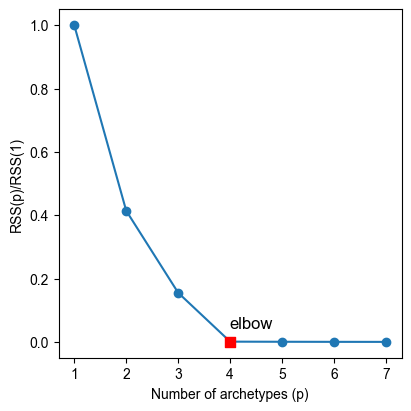

In [7]:
rss_fig, rss_ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
rss_ax.plot(n_archetypes_list, rss_list, marker="o")
rss_ax.set_xlabel("Number of archetypes (p)")
rss_ax.set_ylabel("RSS(p)/RSS(1)")

elbow_index = 4
rss_ax.scatter(
    elbow_index, rss_list[elbow_index - 1], color="red", marker="s", zorder=2, s=60
)
rss_ax.annotate(
    "elbow",
    (4, 0),
    textcoords="offset points",
    xytext=(15, 10),
    ha="center",
    fontsize=12,
)
plt.show()

#### Real Fit
After fitting with 1~7 EMs, you can pick the 4-th element in `aa_list`: `aa = aa_list[3]`, which is already a fitted `AA` instance. `proportion_list[3]` is the mixing proportions. However, If you know how many end-members you need in advance, `multi_AA` is not needed. To demonstrate how to use `AA` directly, we run `AA` with 4 archetypes again in the following cell. For more info about the `multi_AA` function defined, refer to the source code.

In [ ]:
n_archetypes = 4
aa = AA(n_archetypes, **global_aa_params)
mixing_proportions = aa.fit_transform(synthetic_samples)
endmembers_fitted = pd.DataFrame(aa.archetypes_, columns=endmembers.columns)
endmembers_fitted

,A,B,C,D,E,F,G,H
0,1.215498,1.161353,1.002496,0.588563,0.306697,0.269736,0.255832,0.121799
1,0.321752,0.443578,0.906729,1.212633,0.933211,0.536339,0.437723,0.215351
2,0.255941,0.355206,0.201811,0.279074,0.513391,0.851996,1.284134,0.904981
3,0.211744,0.771538,1.135030,0.403336,0.320203,1.164985,0.913450,0.334317


Rearrange rows of `endmembers_fitted` to match the true endmembers. I use cosine similarity to do it automatciallly but it can also be done manually.

In [ ]:
endmembers_fitted, mixing_proportions = match_endmembers(
    endmembers, endmembers_fitted, mixing_proportions
)
endmembers_fitted.to_csv("results/synthetic/AA_noisefree_endmembers.csv")
mixing_proportions.to_csv(
    "results/synthetic/AA_noisefree_mixing_proportions.csv", index=False
)
display(endmembers_fitted)
display(mixing_proportions)

,A,B,C,D,E,F,G,H
EM1,1.215498,1.161353,1.002496,0.588563,0.306697,0.269736,0.255832,0.121799
EM2,0.321752,0.443578,0.906729,1.212633,0.933211,0.536339,0.437723,0.215351
EM3,0.211744,0.771538,1.135030,0.403336,0.320203,1.164985,0.913450,0.334317
EM4,0.255941,0.355206,0.201811,0.279074,0.513391,0.851996,1.284134,0.904981


,EM1,EM2,EM3,EM4
0,0.061176,0.573134,0.208608,0.157082
1,0.028393,0.023428,0.006299,0.941880
2,0.126756,0.193581,0.000000,0.679663
3,0.789912,0.098130,0.030168,0.081790
4,0.171532,0.394930,0.265763,0.167775
...,...,...,...,...
995,0.474712,0.455460,0.010376,0.059452
996,0.329934,0.567201,0.000000,0.102865
997,0.124429,0.806068,0.000000,0.069503
998,0.544731,0.001147,0.230998,0.223124


### Noisy Case

In [8]:
synthetic_samples = pd.read_csv("data/synthetic/noisy_samples.csv")

In [9]:
n_archetypes_list = range(1, 8)
aa_list, proportion_list = multi_AA(
    synthetic_samples, n_archetypes_list, **global_aa_params
)
rss_list = [
    aa.rss_ for aa in aa_list
]  # reconstruction errors (residual sum of squares)

rss_list = normalize_losses(rss_list)  # normalize by the first loss

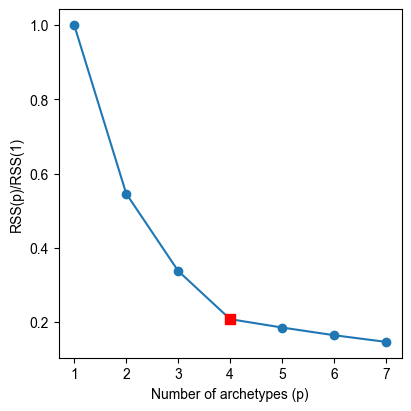

In [10]:
rss_fig, rss_ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
rss_ax.plot(n_archetypes_list, rss_list, marker="o")
rss_ax.set_xlabel("Number of archetypes (p)")
rss_ax.set_ylabel("RSS(p)/RSS(1)")

elbow_index = 4
rss_ax.scatter(
    elbow_index, rss_list[elbow_index - 1], color="red", marker="s", zorder=2, s=60
)
rss_ax.annotate(
    "elbow",
    (4, 0),
    textcoords="offset points",
    xytext=(15, 10),
    ha="center",
    fontsize=12,
)
plt.show()

In [30]:
n_archetypes = 4
aa = AA(n_archetypes, **global_aa_params)
mixing_proportions = aa.fit_transform(synthetic_samples)
endmembers_fitted = pd.DataFrame(aa.archetypes_, columns=endmembers.columns)
endmembers_fitted

,A,B,C,D,E,F,G,H
0,1.165159,1.083586,0.976584,0.585072,0.331710,0.306595,0.288148,0.159727
1,0.301168,0.424948,0.855066,1.219322,0.969301,0.459153,0.435196,0.198718
2,0.234755,0.344871,0.209973,0.291603,0.519861,0.846778,1.276431,0.906515
3,0.265330,0.828842,1.174546,0.412275,0.292931,1.198556,0.932192,0.339887


In [ ]:
endmembers_fitted, mixing_proportions = match_endmembers(
    endmembers, endmembers_fitted, mixing_proportions
)
endmembers_fitted.to_csv("results/synthetic/AA_noisy_endmembers.csv")
mixing_proportions.to_csv(
    "results/synthetic/AA_noisy_mixing_proportions.csv", index=False
)
display(endmembers_fitted)
display(mixing_proportions)

,A,B,C,D,E,F,G,H
EM1,1.165159,1.083586,0.976584,0.585072,0.331710,0.306595,0.288148,0.159727
EM2,0.301168,0.424948,0.855066,1.219322,0.969301,0.459153,0.435196,0.198718
EM3,0.265330,0.828842,1.174546,0.412275,0.292931,1.198556,0.932192,0.339887
EM4,0.234755,0.344871,0.209973,0.291603,0.519861,0.846778,1.276431,0.906515


,EM1,EM2,EM3,EM4
0,0.059207,0.447157,0.214144,0.279492
1,0.114031,0.008816,0.000000,0.877153
2,0.070937,0.115380,0.000000,0.813682
3,0.842347,0.081914,0.011405,0.064334
4,0.182929,0.520410,0.086120,0.210541
...,...,...,...,...
995,0.499753,0.478132,0.001478,0.020637
996,0.478527,0.441016,0.000000,0.080457
997,0.188119,0.747953,0.000000,0.063927
998,0.626650,0.000000,0.001467,0.371883


### Visualization
See [/scripts/plots/plot_synthetic_data_results.py](/scripts/plots/plot_synthetic_data_results.py) for the visualization script, and [/images/synthetic_results.pdf](/images/synthetic_results.pdf) for the figure.

## Example: Panola Dataset

### Load dataset

Data and end-member tables are shown inline.

In [ ]:
panola = pd.read_csv("data/panola/panola_data.csv")
endmembers = pd.read_csv("data/panola/panola_end_members.csv", index_col=0)
endmembers_chemma = pd.read_csv("data/panola/xufei2022_endmembers.csv", index_col=0)
endmembers_chemma = match_endmembers(endmembers, endmembers_chemma)
display(panola)
display(endmembers)

,Alk,SO4,Na,Mg,Ca,Si
0,329.0,13.699781,153.006120,84.73608,118.2156,325.97760
1,329.0,12.899794,152.206088,83.15592,120.7096,328.97280
2,328.0,12.299803,160.406416,82.26708,116.7192,286.34112
3,330.0,11.499816,160.006400,85.62492,114.7240,336.96000
4,322.0,12.899794,152.606104,85.62492,116.2204,331.66848
...,...,...,...,...,...,...
900,297.0,21.041330,169.137200,74.89300,131.6832,367.57760
901,326.4,12.916460,172.180800,80.65400,137.1700,399.36000
902,313.2,12.083140,163.050000,75.71600,121.7072,362.58560
903,306.5,18.541370,156.962800,74.07000,122.2060,349.60640


,Alk,SO4,Na,Mg,Ca,Si
End member,,,,,,
Organic,37,214,23,68,151,60
Hillslope,9,89,46,22,32,90
Groundwater,370,7,169,97,162,422


Rescale each solute to unit variance

In [ ]:
rescaler = StandardScaler(with_mean=False, with_std=True)
panola_scaled = rescaler.fit_transform(panola)

### Determine the number of end-members (skipped)

In [ ]:
n_archetypes_list = range(1, 7)
aa_list, proportion_list = multi_AA(
    panola_scaled, n_archetypes_list, **global_aa_params
)
rss_list = [
    aa.rss_ for aa in aa_list
]  # reconstruction errors (residual sum of squares)

In [ ]:
rss_list = normalize_losses(rss_list)  # normalize by the first loss
rss_fig, rss_ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
rss_ax.plot(n_archetypes_list, rss_list, marker="o")
rss_ax.set_xlabel("Number of archetypes (p)")
rss_ax.set_ylabel("RSS(p)/RSS(1)")

### Fit with 3 end-members
and match with field samples

In [7]:
aa = AA(3, **global_aa_params)
aa.fit(panola_scaled)
endmembers_fitted = aa.archetypes_
endmembers_fitted = rescaler.inverse_transform(endmembers_fitted)
endmembers_fitted = pd.DataFrame(endmembers_fitted, columns=endmembers.columns)
endmembers_fitted = match_endmembers(endmembers, endmembers_fitted)
endmembers_fitted.to_csv("results/panola/endmembers_fitted.csv")
display(endmembers_fitted)
print("RSS:", aa.rss_)

,Alk,SO4,Na,Mg,Ca,Si
End member,,,,,,
Organic,53.123510,205.451757,65.478110,88.777167,180.504441,117.712666
Hillslope,27.732624,79.285272,48.038648,30.209062,45.400580,98.162825
Groundwater,339.560171,10.302263,193.527272,85.181968,136.091596,408.473228


RSS: 399.5495270887503


### Visualization

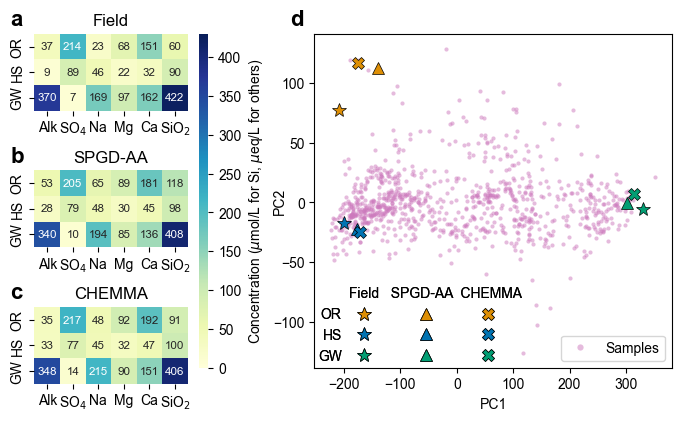

In [ ]:
endmembers_fitted = pd.read_csv("results/panola/endmembers_fitted.csv", index_col=0)

ndim = 2
pca = PCA(n_components=ndim)

fig = plt.figure(figsize=(6.7, 4.1), layout="constrained")
gs = fig.add_gridspec(1, 3, width_ratios=[0.475, 0.025, 0.9])

subgs = gs[0, 0].subgridspec(3, 1, hspace=0.0)


titles = ["Field", "SPGD-AA", "CHEMMA"]
endmember_names = ["OR", "HS", "GW"]
for i, em in enumerate([endmembers, endmembers_fitted, endmembers_chemma]):
    ax = fig.add_subplot(subgs[i, 0])
    heatmap = EndmemberHeatmap(ax)
    heatmap.plot(
        em,
        fmt=".0f",
        vmin=0,
        vmax=430,
        annot_kws={"fontsize": "small"},
        cbar=True if i == 0 else False,
        cbar_ax=fig.add_subplot(gs[:, 1]) if i == 0 else None,
        cbar_kws={"label": r"Concentration ($\mu$mol/L for Si, $\mu$eq/L for others)"},
        xticklabels=[
            "Alk",
            r"SO${_4}$",
            "Na",
            "Mg",
            "Ca",
            r"SiO$_2$",
        ],  # [x if x != "SO4" else r"SO${_4}$" for x in em.columns],
        yticklabels=endmember_names,
    )
    ax.set_ylabel("")
    ax.set_title(titles[i])


ax = fig.add_subplot(gs[:, 2])
scatter = Scatter(ax)
ax.set_ylabel("PC2", labelpad=-10)
sample_lines = scatter.plot_samples(
    pca.fit_transform(panola),
    color=default_palette[4],
    alpha=0.5,
    markeredgecolor="none",
    label="Samples",
)

endmember_colors = [default_palette[i] for i in [1, 0, 2]]

# Define the markers, labels, endmember data, and markersizes
markers = ["*", "^", "X"]
labels = [endmember_names, [" "] * 3, [" "] * 3]
endmember_data = [endmembers, endmembers_fitted, endmembers_chemma]
markersizes = [10, 8, 8]

# Plot each endmember using a for loop and zip
em_lines = []
for marker, label, em, markersize in zip(markers, labels, endmember_data, markersizes):
    line = scatter.plot_each_endmember(
        pca.transform(em),
        marker=marker,
        colors=endmember_colors,
        markeredgecolor="black",
        markeredgewidth=0.5,
        labels=label,
        markersize=markersize,
    )
    em_lines.extend(line)

# Legends
sample_legend = ax.legend(
    handles=[
        sample_lines,
    ],
    markerscale=1.5,
    loc="lower right",
    frameon=True,
)

ax.add_artist(sample_legend)


legend = ax.legend(
    handles=em_lines,
    ncols=3,
    title="        Field   SPGD-AA  CHEMMA",
    loc="lower left",
    bbox_to_anchor=(-0.049, -0.049),
    alignment="left",
    markerfirst=False,
    handletextpad=0.6,
    columnspacing=1.6,
    borderpad=1.0,
    #    frameon=True,
)

ax.add_artist(legend)

for label, ax in zip(["a", "b", "c", "d"], [fig.axes[i] for i in [0, 2, 3, 4]]):
    ax.annotate(
        label,
        (0.0, 1),
        xycoords="axes fraction",
        xytext=(-1.1, 1.1),
        textcoords="offset fontsize",
        fontsize=16,
        verticalalignment="top",
        fontweight="bold",
    )

fig.savefig("images/panola_results.pdf", bbox_inches="tight")

### Compare RSS with CHEMMA results

CHEMMA Mixing proportions calculated using SPGD.

In [8]:
rss_1archetype = AA(1, **global_aa_params).fit(panola_scaled).rss_
aa_for_comparison = AA(3, **global_aa_params).fit(panola_scaled)
endmembers_chemma_rescaled = rescaler.transform(endmembers_chemma)
aa_for_comparison.archetypes_ = endmembers_chemma_rescaled
chemma_mixing_proportions = aa_for_comparison.transform(panola_scaled)
rss_chemma = (
    np.linalg.norm(
        panola_scaled - chemma_mixing_proportions @ endmembers_chemma_rescaled
    )
    ** 2
)
endmembers_field_scaled = rescaler.transform(endmembers)
aa_for_comparison.archetypes_ = endmembers_field_scaled
field_mixing_proportions = aa_for_comparison.transform(panola_scaled)
rss_field = np.linalg.norm(
    panola_scaled - field_mixing_proportions @ endmembers_field_scaled
) ** 2

print("RSS for 1 archetype:", rss_1archetype)
print("RSS for CHEMMA:", rss_chemma)
print("RSS for field endmembers:", rss_field)
print("Normalized RSS for SPGD-AA:", aa.rss_ / rss_1archetype)
print("Normalized RSS for CHEMMA:", rss_chemma / rss_1archetype)
print("Normalized RSS for field endmembers:", rss_field / rss_1archetype)

RSS for 1 archetype: 5430.000000000003
RSS for CHEMMA: 473.6174336577761
RSS for field endmembers: 588.5387605214374
Normalized RSS for SPGD-AA: 0.07358186502555251
Normalized RSS for CHEMMA: 0.0872223634728869
Normalized RSS for field endmembers: 0.10838651206656301


## Example: Nazca Dataset

### Load dataset
Data, Leinen & Pisias (1984) end-members, Dymond (1981) end-members are shown inline.

In [4]:
warnings.filterwarnings("ignore")
nazca = pd.read_excel(
    "data/nazca/ggge20247-sup-001a-supinfo1a.xlsx", usecols="B:I", header=1
)
warnings.filterwarnings("default")

# Leinen and Pisias (1984) endmember fractions (Q-mode FA)
endmember_lp = pd.read_csv("data/nazca/LP1984_endmember_fraction.csv", index_col=0)

# Dymond (1981) endmember fractions
endmember_dymond = pd.read_csv(
    "data/nazca/Dymond1981_endmember_fraction.csv", index_col=0
)

display(nazca)
display(endmember_lp)
display(endmember_dymond)

,Al (ppm),Si (ppm),Mn (ppm),Fe (ppm),Cu (ppm),Ni (ppm),Zn (ppm),Ba (ppm)
0,36631,191426,54780,114041,815,977,584,46339
1,20805,141861,40982,136607,648,919,328,24423
2,38622,164004,44740,127039,1262,1147,869,19647
3,23551,301714,17081,99816,725,897,512,16728
4,7778,238060,27012,73047,184,405,206,7954
...,...,...,...,...,...,...,...,...
322,72098,287647,3633,47465,197,327,229,11986
323,76096,279736,2664,42746,219,397,265,5934
324,61579,241985,18588,51200,606,672,263,23601
325,35601,159538,69483,165953,1669,1554,494,21224


,Al,Si,Mn,Fe,Cu,Ni,Zn,Ba
Detrital,0.25157,0.49987,0.04830,0.19522,0.00146,0.00277,0.00050,0.00030
Hydrothermal,0.00374,0.01421,0.22807,0.74778,0.00322,0.00157,0.00135,0.00007
Biogenic,0.00751,0.68264,0.04505,0.23346,0.00130,0.00000,0.00068,0.02935
Authigenic,0.01630,0.73356,0.20947,0.00000,0.00391,0.00815,0.00049,0.02812
Dissolution Residue,0.15939,0.00000,0.17344,0.34748,0.00672,0.00550,0.00214,0.30534


,Al,Si,Mn,Fe,Cu,Ni,Zn,Ba
Detrital,0.211323,0.633968,0.003381,0.147926,0.000254,0.000317,0.000296,0.002536
Hydrothermal,0.004172,0.090403,0.201669,0.695410,0.002921,0.000626,0.001321,0.003477
Biogenic,0.001990,0.994834,0.000023,0.000995,0.000050,0.000040,0.000080,0.001990
Authigenic,0.028409,0.085227,0.568182,0.284091,0.009470,0.018939,0.001894,0.003788
Dissolution Residue,0.265463,0.000000,0.003716,0.185824,0.008495,0.003451,0.002124,0.530926


### Preprocessing
Convert to fraction

In [5]:
nazca_normalized = normalize(
    nazca, norm="l1", axis=1
)  # convert (divide by sum of total 8 elements)
nazca_normalized = pd.DataFrame(
    nazca_normalized, columns=endmember_lp.columns, index=nazca.index
)

# Not used
rescaler = StandardScaler(with_mean=False, with_std=False)
nazca_scaled = rescaler.fit_transform(nazca_normalized.values)

### Run AA

In [ ]:
aa = AA(n_archetypes=5, **global_aa_params)

aa.fit(nazca_scaled)
archetypes = aa.archetypes_
endmembers_fitted = rescaler.inverse_transform(archetypes)
endmembers_fitted = pd.DataFrame(endmembers_fitted, columns=endmember_lp.columns)
endmembers_fitted = match_endmembers(endmember_dymond, endmembers_fitted)
endmembers_fitted.to_csv("results/nazca/endmembers_fitted.csv")
endmembers_fitted

,Al,Si,Mn,Fe,Cu,Ni,Zn,Ba
Detrital,0.215175,0.604252,0.020829,0.148637,0.000575,0.000707,0.000445,0.009381
Hydrothermal,0.013067,0.116181,0.147993,0.705385,0.001328,0.002765,0.001247,0.012034
Biogenic,0.043955,0.824586,0.008264,0.093984,0.000481,0.000984,0.000698,0.027048
Authigenic,0.020796,0.133865,0.464403,0.341853,0.003840,0.001853,0.000845,0.032545
Dissolution Residue,0.191366,0.318383,0.065445,0.229944,0.003184,0.006430,0.001294,0.183955


### Visualization

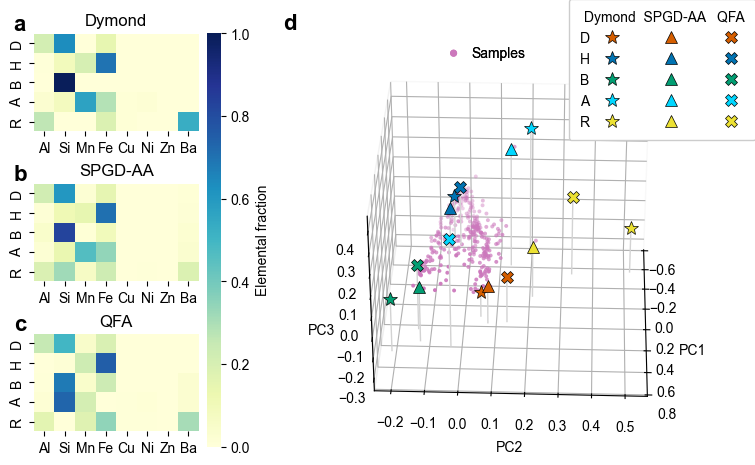

In [6]:
endmembers_fitted = pd.read_csv("results/nazca/endmembers_fitted.csv", index_col=0)

ndim = 3
pca = PCA(n_components=ndim)

pca_nazca = pca.fit_transform(nazca_normalized)
pca_endmembers_dymond = pca.transform(endmember_dymond)
pca_endmembers_fitted = pca.transform(endmembers_fitted)
pca_endmembers_lp = pca.transform(endmember_lp)

fig = plt.figure(figsize=(7.4, 4.5), layout="constrained")
gs = fig.add_gridspec(1, 3, width_ratios=[0.425, 0.03, 1])

subgs = gs[0, 0].subgridspec(3, 1, hspace=0.0)
titles = ["Dymond", "SPGD-AA", "QFA"]

endmember_names = ["D", "H", "B", "A", "R"]
for i, em in enumerate([endmember_dymond, endmembers_fitted, endmember_lp]):
    ax = fig.add_subplot(subgs[i, 0])
    heatmap = EndmemberHeatmap(ax)
    heatmap.plot(
        em,
        annot=False,
        vmin=0,
        vmax=1,
        cbar=True if i == 0 else False,
        cbar_ax=fig.add_subplot(gs[:, 1]) if i == 0 else None,
        cbar_kws={"label": "Elemental fraction"},
        yticklabels=endmember_names,
        #        norm=LogNorm(vmin=1e-5, vmax=1),
    )
    ax.set_ylabel("")
    ax.set_title(titles[i])

ax = fig.add_subplot(gs[:, 2], projection="3d")
scatter = Scatter(ax, ndim=ndim)

sample_line = scatter.scatter(
    pca_nazca,
    color=default_palette[4],
    s=32,
    edgecolors="none",
    label="Samples",
    zorder=5,
)

ax.add_artist(
    ax.legend(
        handles=[sample_line],
        loc="upper left",
        bbox_to_anchor=(0.3, 1),
        markerscale=1.8,
        handletextpad=0.3,
        #    frameon=True,
    )
)

colors = [default_palette[i] for i in [3, 0, 2, 1, 8]]
colors[3] = sns.color_palette("bright")[9]

# Define the markers, labels, endmember data, and markersizes
markers = ["*", "^", "X"]
labels = [endmember_names, [" "] * 5, [" "] * 5]
endmember_data = [pca_endmembers_dymond, pca_endmembers_fitted, pca_endmembers_lp]
markersizes = [10, 8, 8]

# Plot each endmember using a for loop and zip
lines = []
for marker, label, em, markersize in zip(markers, labels, endmember_data, markersizes):
    line = scatter.plot_each_endmember(
        em,
        marker=marker,
        markersize=markersize,
        markeredgecolor="black",
        markeredgewidth=0.5,
        colors=colors,
        labels=label,
        zorder=6,
    )
    lines.extend(line)

# scatter.stem_samples(pca_nazca)
scatter.stem_samples(pca_endmembers_dymond)
scatter.stem_samples(pca_endmembers_fitted)
scatter.stem_samples(pca_endmembers_lp)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(azim=2, elev=32)
fig.legend(
    handles=lines,
    ncols=3,
    title=" Dymond  SPGD-AA   QFA",
    loc="upper right",
    handletextpad=0.6,
    borderaxespad=0,
    borderpad=0.8,
    columnspacing=1.4,
    markerfirst=False,
    # edgecolor="none",
    frameon=True,
    framealpha=1,
)

ax.set_xlabel("PC1", labelpad=8)

for label, ax in zip("abcd", [fig.axes[i] for i in [0, 2, 3, 4]]):
    ax.annotate(
        label,
        (0.0, 1),
        xycoords="axes fraction",
        xytext=(-0.9, 0.9) if i != 4 else (1.2, 0.9),
        textcoords="offset fontsize",
        fontsize=16,
        verticalalignment="top",
        fontweight="bold",
    )


fig.savefig(
    "images/nazca_results.pdf",
    bbox_inches="tight",
)

## Example: Jasper Ridge Remote Sensing Subimage #2

### Load and prepare dataset

In [ ]:
jasper_endmembers = scipy.io.loadmat("data/jasper_ridge/end4.mat")["M"].T  # transposed!
n_bands = range(1, jasper_endmembers.shape[-1] + 1)

f = spectral.open_image("data/jasper_ridge/jasperRidge2_R198.hdr")
jasper = f.load()
jasper = jasper.reshape(-1, jasper.shape[-1])  # reshape to 2D

normalize ground truth end-members

In [ ]:
endmembers_normalized = normalize(jasper_endmembers, axis=1)

In the cell below, we try to find the pixels in the image (l1 normalized) that matches the ground truth end-members best.

This was used in the EDAA and can be skipped.

In [ ]:
jasper_normalized = normalize(jasper, axis=1)
endmembers_rescaled = np.zeros_like(jasper_endmembers)
for i, endmember in enumerate(endmembers_normalized):
    idx = np.argmax(jasper_normalized @ endmember)
    endmembers_rescaled[i] = jasper[idx]

In [ ]:
scaler = StandardScaler(with_mean=False, with_std=False)  # no transformation is applied
jasper_scaled = scaler.fit_transform(jasper)

### Run AA and save results

In [ ]:
aa = AA(n_archetypes=4, **global_aa_params)
aa.fit(jasper_scaled)
endmembers_fitted = scaler.inverse_transform(aa.archetypes_)
endmembers_fitted_normalized = normalize(endmembers_fitted, axis=1)
endmembers_fitted_normalized = match_endmembers(
    endmembers_normalized, endmembers_fitted_normalized
)
np.save("results/jasper_ridge/endmembers_fitted.npy", endmembers_fitted)
np.save(
    "results/jasper_ridge/endmembers_fitted_normalized.npy",
    endmembers_fitted_normalized,
)

### Visualization

In [ ]:
# upper panel
endmembers_fitted = np.load("results/jasper_ridge/endmembers_fitted.npy")
endmembers_fitted_normalized = np.load(
    "results/jasper_ridge/endmembers_fitted_normalized.npy"
)

fig, axs = plt.subplots(
    nrows=2, figsize=(4.6, 5.3), height_ratios=[1, 1], layout="constrained"
)
for ax in axs:
    ax.set_prop_cycle(color=default_palette)
endmember_names = ["Tree", "Soil", "Water", "Road"]
ax = axs[0]
for i in range(len(endmembers_normalized)):
    ax.plot(
        n_bands,
        endmembers_normalized[i],
        color=default_palette[i],
        label=endmember_names[i],
    )
for i in range(len(endmembers_fitted_normalized)):
    ax.plot(
        n_bands,
        endmembers_fitted_normalized[i],
        color=default_palette[i],
        linestyle="--",
        label=" ",
    )

ax.legend(
    ncols=2,
    title="                  GT    SPGD-AA",
    loc="upper right",
    markerfirst=False,
    handletextpad=1.0,
    borderaxespad=0.1,
    columnspacing=0.8,
)
ax.set_xlabel("Bands")
ax.set_ylabel(r"$\ell_2$-normalized reflectance")
ax.set_ylim(bottom=0)
ax.set_xlim(0, 200)

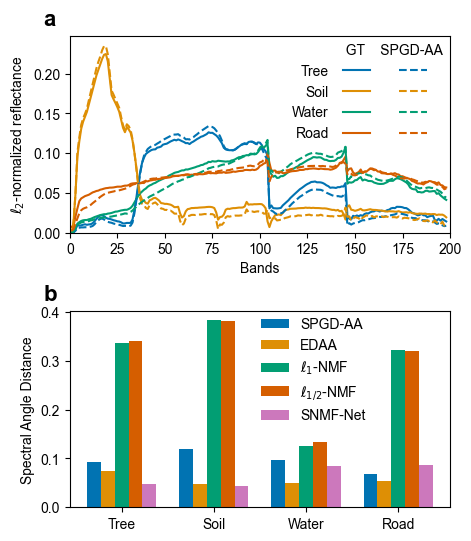

In [ ]:
# lower panel
SADs = {
    "SPGD-AA": [
        spectral_angle_distances(
            endmembers_normalized[i], endmembers_fitted_normalized[i]
        )
        for i in range(len(endmembers_normalized))
    ],
    "EDAA": np.radians([4.23, 2.74, 2.80, 3.10]),
    r"$\ell_1$-NMF": np.array([0.3369, 0.3836, 0.1246, 0.323]),  # Xu 2020 Curvelet
    r"$\ell_{1/2}$-NMF": np.array([0.3412, 0.3821, 0.1341, 0.3213]),  # Xu 2020 Curvelet
    "SNMF-Net": np.array([0.0478, 0.0443, 0.0855, 0.0875]),  # Xiong2022 SNMF-net
}

label_locs = np.arange(len(endmember_names))
width = 0.15

ax = axs[1]

for i, (attribute, measurement) in enumerate(SADs.items()):
    offset = width * i
    rects = ax.bar(label_locs + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, fmt="%.2f", padding=3)

ax.set_ylabel("Spectral Angle Distance")
ax.set_xticks(label_locs + 2 * width, endmember_names)
ax.legend(loc="upper center", bbox_to_anchor=(0.64, 1.03))


for label, ax in zip(
    [
        "a",
        "b",
    ],
    fig.axes,
):
    ax.annotate(
        label,
        (0.0, 1),
        xycoords="axes fraction",
        xytext=(-1.2, 1.2),
        textcoords="offset fontsize",
        fontsize=16,
        verticalalignment="top",
        fontweight="bold",
    )

fig.savefig("images/jasper_results.pdf", bbox_inches="tight")
fig